In [ ]:
import pandas as pd
import io
import numpy as np
# import joblib
from sklearn.preprocessing import LabelEncoder,StandardScaler,label_binarize
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import re
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

from snowflake.snowpark.context import get_active_session
session = get_active_session()

In [ ]:
def fetch_from_table_data(session,table_name):
    table_data = session.table(table_name)
    return table_data

data_h2=fetch_from_table_data(session,"H2")

In [ ]:
def create_dataframe(data):
    df=data.to_pandas()
    return df

df_H2=create_dataframe(data_h2)


,0
NO,16681
TIME,16681
SOURCE,16681
DESTINATION,16681
PROTOCOL,16681
LENGTH,16681
INFO,16681
TYPE,16681
TYPE_OF_ATTACK,16681


In [ ]:
def preprocess_x(train_df,test_df):

    # Drop unnecessary columns
    train_df = train_df.drop(['NO', 'TIME', 'TYPE', 'SOURCE', 'DESTINATION'], axis=1)
    test_df = test_df.drop(['NO', 'TIME', 'TYPE', 'SOURCE', 'DESTINATION'], axis=1)

    # Analyze the 'INFO' column to create a new column based on the provided patterns

    def determine_info_type(row):
      # Initialize with default value
      info_type = 'Normal'

      rst_fin_pattern = r'RST|FIN'
      psh_pattern = r'PSH'
      syn_pattern = r'SYN'

      protocols = ['DNS', 'LLC', 'UDP', 'DHCP', 'TLSv1.1', 'HTTP', 'TLSv1.2', 'OCSP']

      if row['PROTOCOL'] == 'TCP' and row['LENGTH'] in [54, 66] and re.search(rst_fin_pattern, row['INFO']):
          info_type = 'Nmap'
      elif row['PROTOCOL'] == 'TCP' and re.search(psh_pattern, row['INFO']):
          info_type = 'DoS'
      elif row['PROTOCOL'] == 'TCP' and re.search(syn_pattern, row['INFO']):
          info_type = 'Normal'
      elif row['PROTOCOL'] == 'ICMP':
          info_type = 'SMURF'
      elif row['PROTOCOL'] == 'ARP':
          info_type = 'ARP'
      elif row['PROTOCOL'] in protocols:
          info_type = 'Normal'

      return info_type

    # Apply the function to each row in the DataFrame
    train_df['INFO_TYPE'] = train_df.apply(determine_info_type, axis=1)
    test_df['INFO_TYPE'] = test_df.apply(determine_info_type, axis=1)

    # One-hot encode PROTOCOL and INFO_Type
    protocol_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    info_type_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit on train, transform on both train and test
    protocol_encoder.fit(train_df[['PROTOCOL']])
    one_hot_protocol_train = protocol_encoder.transform(train_df[['PROTOCOL']])
    one_hot_protocol_test = protocol_encoder.transform(test_df[['PROTOCOL']])

    info_type_encoder.fit(train_df[['INFO_TYPE']])
    one_hot_info_type_train = info_type_encoder.transform(train_df[['INFO_TYPE']])
    one_hot_info_type_test = info_type_encoder.transform(test_df[['INFO_TYPE']])

    # Convert to DataFrame with appropriate column names
    one_hot_protocol_train_df = pd.DataFrame(one_hot_protocol_train, columns=protocol_encoder.get_feature_names_out(['PROTOCOL']))
    one_hot_protocol_test_df = pd.DataFrame(one_hot_protocol_test, columns=protocol_encoder.get_feature_names_out(['PROTOCOL']))

    one_hot_info_type_train_df = pd.DataFrame(one_hot_info_type_train, columns=info_type_encoder.get_feature_names_out(['INFO_TYPE']))
    one_hot_info_type_test_df = pd.DataFrame(one_hot_info_type_test, columns=info_type_encoder.get_feature_names_out(['INFO_TYPE']))

    # Concatenate the one-hot encoded columns back to the DataFrames
    final_train_df = pd.concat([train_df.reset_index(drop=True), one_hot_protocol_train_df, one_hot_info_type_train_df], axis=1)
    final_test_df = pd.concat([test_df.reset_index(drop=True), one_hot_protocol_test_df, one_hot_info_type_test_df], axis=1)

    # Drop the original columns
    final_train_df.drop(['PROTOCOL', 'INFO_TYPE', 'INFO'], axis=1, inplace=True)
    final_test_df.drop(['PROTOCOL', 'INFO_TYPE', 'INFO'], axis=1, inplace=True)
    # final_csv_path = 'train.csv'
    # final_train_df.to_csv(final_csv_path, index=False)
    # final_csv_path = 'test.csv'
    # final_test_df.to_csv(final_csv_path, index=False)
    return final_train_df,final_test_df


In [ ]:
def preprocess_y(y):
    # Initialize the encoder
    onehot_encoder = OneHotEncoder(sparse_output=False)

    # Fit and transform y_train
    y_encoded = onehot_encoder.fit_transform(y.values.reshape(-1, 1))

    # Get the class names (original labels)
    class_names = onehot_encoder.categories_[0]

    # Return both the encoded labels and the class names
    return y_encoded, class_names

In [ ]:
def data_stratified_split_train_test(df):
    x=df.drop(['TYPE_OF_ATTACK'],axis=1)
    y=df['TYPE_OF_ATTACK']

    # Check protocol distribution
    protocol_counts = df['PROTOCOL'].value_counts()
    print(protocol_counts)  # Optional: To see the distribution

    # Handle rare protocols if necessary
    # For example, removing protocols with less than 2 occurrences
    rare_protocols = protocol_counts[protocol_counts < 2].index
    df_filtered = df[~df['PROTOCOL'].isin(rare_protocols)]

    x_filtered = df_filtered.drop(['TYPE_OF_ATTACK'], axis=1)
    y_filtered = df_filtered['TYPE_OF_ATTACK']

    # Initialize StratifiedShuffleSplit
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # Perform the split
    for train_index, test_index in stratified_split.split(x_filtered, df_filtered['PROTOCOL']):
        x_train = x_filtered.iloc[train_index]
        x_test = x_filtered.iloc[test_index]
        y_train = y_filtered.iloc[train_index]
        y_test = y_filtered.iloc[test_index]

    return x_train,x_test,y_train,y_test

x_train_raw,x_test_raw,y_train_raw,y_test_raw=data_stratified_split_train_test(df_H2)

print(x_train_raw.shape)
print(y_train_raw.shape)
#preprocess the data
x_train,x_test=preprocess_x(x_train_raw,x_test_raw)


print(x_train.shape)
print(x_test.shape)

#preprocess the labels
y_train, class_name=preprocess_y(y_train_raw)
y_test,class_name=preprocess_y(y_test_raw)

print(class_name)

PROTOCOL
ICMP       11688
TCP         3507
TLSv1.2      910
ARP          354
DNS          179
OCSP          25
TLSv1.1       13
DHCP           2
HTTP           2
UDP            1
Name: count, dtype: int64
(13344, 8)
(13344,)
(13344, 15)
(3336, 15)
['ARP Spoofing' 'DoS Attack' 'Nmap Port Scan' 'No Attack' 'Smurf Attack']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

In [ ]:
print(x_train.shape)
print(y_train.shape)
# print(x.shape)
# print(y.shape)

(13344, 15)
(13344, 5)


In [ ]:
def create_model(input_dim):
    model=Sequential([
        Dense(64,input_dim=input_dim,activation='relu'),
        Dense(32,activation='relu'),
        Dense(5,activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

def client_training(x_train, y_train, input_dim):
    model = create_model(input_dim)
    
    # Set up a checkpoint to save the best model based on validation accuracy
    checkpoint = ModelCheckpoint(
        'client_model2.h5',  # filepath where the model will be saved
        monitor='val_accuracy',  # monitor validation accuracy
        verbose=1,  # verbosity mode
        save_best_only=True,  # only save when the monitored metric improves
        mode='max'  # max mode to save the model with the highest accuracy
    )

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

    # Fit the model with validation data
    model.fit(x_train, y_train, epochs=500, batch_size=32, verbose=1, validation_split=0.2, callbacks=[checkpoint,early_stopping])
    
    return model


In [ ]:
client_model2=client_training(x_train,y_train,x_train.shape[1])
client_model2.save('client_model2.h5')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8297 - loss: 1.6160
Epoch 2/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9898 - loss: 0.0801
Epoch 3/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9844 - loss: 0.1267
Epoch 4/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9943 - loss: 0.0347
Epoch 5/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9929 - loss: 0.0374
Epoch 6/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9918 - loss: 0.0315
Epoch 7/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9888 - loss: 0.0684
Epoch 8/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9912 - loss: 0.0289
Epoch 9/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9916 - loss: 0.0271
Epoch 10/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9930 - loss: 0.0169


In [ ]:
# Step 4: Define the version number
version = "v2"  # Increment this version number as needed

In [ ]:
# Upload model.h5 file to Snowflake stage
session.file.put("client_model2.h5", f"@client2_model_stage/{version}/")

In [ ]:
client_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,809 (38.32 KB)

 Trainable params: 3,269 (12.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,540 (25.55 KB)

Extracting the weights and converting them into a format that can be serialized to JSON, typically as lists of numbers since JSON does not directly support NumPy arrays

In [ ]:
import json

# Extract the configuration of the model
model_config = client_model2.get_config()

# Prepare a dictionary to store the weights
model_weights = {}

# Iterate over each layer in the model
for layer in client_model2.layers:
    weights = layer.get_weights()  # Get the weights of the current layer
    layer_weights = []  # List to store the current layer's weights

    print(f'Layer: {layer.name}')

    for i, weight_array in enumerate(weights):
        print(f"  Weights {i+1} shape: {weight_array.shape}")
        print(weight_array)

        # Convert each weight array to a list and append it to the layer's weights
        layer_weights.append(weight_array.tolist())

    # Add the layer's weights to the model_weights dictionary
    model_weights[layer.name] = layer_weights

# Save the weights to a JSON file
with open(f'model_weights2_{version}.json', 'w') as json_file:
    json.dump(model_weights, json_file, indent=2)

print(f"Weights have been saved to model_weights2_{version}.json")


Layer: dense_3
  Weights 1 shape: (15, 64)
[[-1.51490629e-01 -8.74011517e-02 -2.37106442e-01 -7.28553981e-02
  -2.74504483e-01 -1.63205475e-01 -5.68854511e-02 -1.24972612e-02
  -6.48663044e-02 -2.24841565e-01 -1.75444186e-01 -2.37917289e-01
  -7.64040798e-02 -5.48201762e-02 -5.24047650e-02 -1.37486011e-01
  -1.64021224e-01  1.19347656e-02 -3.69589925e-02  4.70465571e-02
  -2.00745404e-01 -2.31780503e-02 -6.01793267e-02 -1.48190081e-01
  -4.07941639e-02 -7.94780031e-02 -7.82002062e-02 -5.74454814e-02
  -4.23948765e-02 -9.10989102e-03 -2.08336134e-02 -2.14573778e-02
  -4.29102033e-02 -7.62516931e-02 -6.10792600e-02 -1.82683632e-01
  -1.97902277e-01 -2.11752027e-01 -1.40106557e-02 -8.64670873e-02
  -9.39646885e-02 -1.14582352e-01 -1.89120024e-01  2.73686741e-02
  -6.88829571e-02 -3.49574201e-02 -9.09236372e-02 -1.78332418e-01
  -3.06072980e-02 -3.48991342e-02 -2.20290408e-01 -6.60197213e-02
  -2.38369629e-01 -1.06873468e-01 -2.15625688e-01 -1.69465184e-01
  -1.69855803e-02 -5.12890518e-02

In [ ]:
# Upload model weights JSON file to Snowflake stage
session.file.put(f'model_weights2_{version}.json', f"@client2_model_stage/{version}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


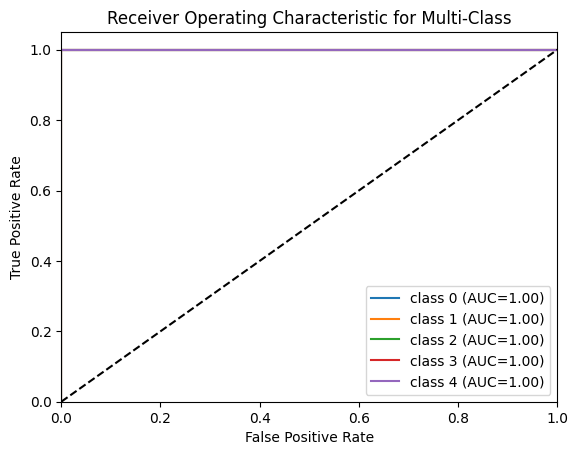

In [ ]:
y_pred_prob=client_model2.predict(x_test)
# For sparse categorical crossentropy, we need to use argmax to get class labels
y_pred = np.argmax(y_pred_prob, axis=1)
from sklearn.preprocessing import label_binarize
n_classes=y_pred_prob.shape[1]
y1_test_binarized=label_binarize(y_test,classes=np.arange(n_classes))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr=dict()
tpr=dict()
roc_auc=dict()

for i in range(n_classes):
    fpr[i],tpr[i],_=roc_curve(y1_test_binarized[:,i],y_pred_prob[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i],tpr[i],label=f'class {i} (AUC={roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Ensure y_test is in multiclass format (if it was one-hot encoded)
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Ensure y_pred is in multiclass format (if it was one-hot encoded)
if y_pred.ndim > 1 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate a classification report
class_report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(5)], zero_division=0)

conf_matrix, class_report

(array([[  71,    0,    0,    0,    0],
        [   0,   14,    0,    0,    0],
        [   0,    0,  211,    0,    0],
        [   0,    0,    0,  702,    0],
        [   0,    1,    0,    0, 2337]]),
 '              precision    recall  f1-score   support\n\n     Class 0       1.00      1.00      1.00        71\n     Class 1       0.93      1.00      0.97        14\n     Class 2       1.00      1.00      1.00       211\n     Class 3       1.00      1.00      1.00       702\n     Class 4       1.00      1.00      1.00      2338\n\n    accuracy                           1.00      3336\n   macro avg       0.99      1.00      0.99      3336\nweighted avg       1.00      1.00      1.00      3336\n')

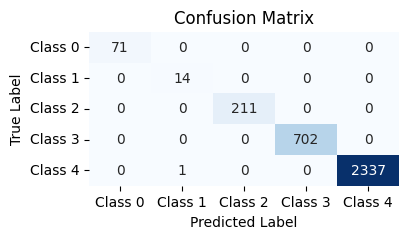

In [ ]:

import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Class {i}' for i in range(n_classes)],
            yticklabels=[f'Class {i}' for i in range(n_classes)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted',zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F1 Score: 0.9997
